In [9]:
library(ggplot2)
library(plyr)
library(dplyr)
library(data.table)
library(tidyr)
library(tidyverse)
library(ggplot2)
library(ggsignif) 
library(ggpubr) 
library(reshape2)
library(ggsci) 
library(stringr)
library(ggvenn)
library(ggpubr)

options(repr.matrix.max.rows=600, repr.matrix.max.cols=200) 
options(repr.plot.width = 6, repr.plot.height = 6)

In [4]:
# 利用k nearest挖掘T1-T5,各自最接近的部位

jac_long<-fread("Fig5F.sample_seq_overlap_addflag.csv") %>% as.data.frame()
jac_LoT<-jac_long[jac_long$flag=="self.ToT",]

Single_T_jac_level<-tibble()
samples<-unique(jac_LoT$sample1)[order(unique(jac_LoT$sample1),decreasing = FALSE)]
for (s in samples){
    data_s<-jac_LoT[jac_LoT$sample1==s,]
    row_s<-c(s,mean(data_s$jaccard_index),median(data_s$jaccard_index),data_s$sample2[order(data_s$jaccard_index,decreasing = TRUE)[1]])
    Single_T_jac_level<-rbind(Single_T_jac_level,row_s)
}

colnames(Single_T_jac_level)<-c("sample","average_jaccard","median_jaccard","closest_sample")

Single_T_jac_level$closest_pos<-substr(Single_T_jac_level$closest_sample,8,9)
Single_T_jac_level$type<-substr(Single_T_jac_level$sample,8,9)

Single_T_jac_level$sHIG=1-as.numeric(Single_T_jac_level$average_jaccard)

sHIG_closest_pos<-Single_T_jac_level[,c(1,4,6,5,7)]

sHIG_closest_pos[1:3,]
colnames(sHIG_closest_pos)=c('sample','sample.nearest','position','position.nearest','sHIG')
#write.csv(sHIG_closest_pos,"Sup.table_sHIG_closest_pos.csv",quote=FALSE,row.names=FALSE)



,sample,closest_sample,type,closest_pos,sHIG
,<chr>,<chr>,<chr>,<chr>,<dbl>
1,ESCC001T1,ESCC001T5,T1,T5,0.9412713
2,ESCC001T2,ESCC001T3,T2,T3,0.9447720
3,ESCC001T3,ESCC001T5,T3,T5,0.9381510


### 【***】计算Single_T_jac_level中average_jaccard与哪些基因相关

## Fig5F

[1] 4130    4

[1] 1858    4

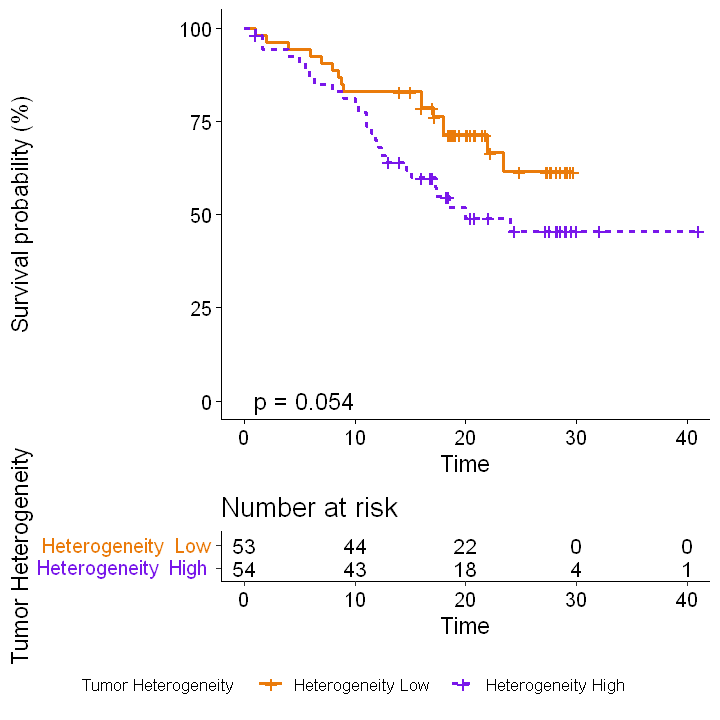

In [11]:
jac_long<-fread("Fig5F.sample_seq_overlap_addflag.csv") %>% as.data.frame()
jac_long_self<-jac_long[-grep("between",jac_long$flag),]

dim(jac_long_self)
jac_long_self1<-jac_long_self[jac_long_self$flag=="self.ToT",]
dim(jac_long_self1)
jac_long_self1$patient<-substr(jac_long_self1$sample1,1,7)

patient_jac_level<-tibble()
for(p in sort(unique(jac_long_self1$patient))){
    data_p<-jac_long_self1[jac_long_self1$patient==p,]
    row_p<-c(p,median(data_p$jaccard_index),mean(data_p$jaccard_index))
    patient_jac_level<-rbind(patient_jac_level,row_p)
}

colnames(patient_jac_level)<-c("patient","median_jaccard","mean_jaccard")
options(repr.plot.width = 6, repr.plot.height = 6)

library(survival)
library(survminer)

MR_survival_gene_data<-fread("Fig5F.MR_survival_gene_data.test.csv") %>% as.data.frame(check.names=FALSE)
rows_selected<-!duplicated(MR_survival_gene_data$Patient_ID)
cols_selected<-colnames(MR_survival_gene_data) %in% c('Patient_ID','Gender','Age','Location','Smoking_status','Drinking_status','T','N','M','TNM','Tumor_grade','Lymphatic_metastasis','Survival_status','Survival_time')
MR_survival_data<-MR_survival_gene_data[rows_selected,cols_selected]
colnames(MR_survival_data)[1]<-"patient"

MR_survival_data_jaccard<-merge(MR_survival_data,patient_jac_level,by="patient")
T_survival_gene<-MR_survival_data_jaccard

gene="mean_jaccard" 
T_survival_gene$gene_flag[T_survival_gene[,gene]>median(T_survival_gene[,gene])]<-"high"# heterogeneity low
T_survival_gene$gene_flag[T_survival_gene[,gene]<=median(T_survival_gene[,gene])]<-"low"# heterogeneity high

fit<-survfit(Surv(Survival_time,Survival_status) ~gene_flag, data=T_survival_gene)

xx<-ggsurvplot(fit, data = T_survival_gene,
           conf.int = FALSE,
           pval = TRUE,
           fun = "pct",
           risk.table = TRUE,
           size = 1,
           linetype = "strata",
           palette = c(rgb(234,123,11,maxColorValue=255),rgb(121,23,234,maxColorValue=255)),
           legend = "bottom",
           legend.labs = c("Heterogeneity Low","Heterogeneity High"),
           legend.title=("Tumor Heterogeneity"),
           add.title=("Tumor Heterogeneity")
           )
print(xx)


In [15]:
colnames(T_survival_gene)[ncol(T_survival_gene)]<-"Patient_heterogenity_flag"
T_survival_gene_selected<-T_survival_gene[,c(1,13,14,15,16,17)]
T_survival_gene_selected[1:3,]
write.csv(T_survival_gene_selected,"Fig5F.csv",row.names=FALSE,)

,patient,Survival_status,Survival_time,median_jaccard,mean_jaccard,Patient_heterogenity_flag
,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>
1,ESCC001,0,14,0.0549113596591341,0.0560223044132808,low
2,ESCC002,0,13,0,0.00401104664166154,low
3,ESCC004,0,32,0,0,low


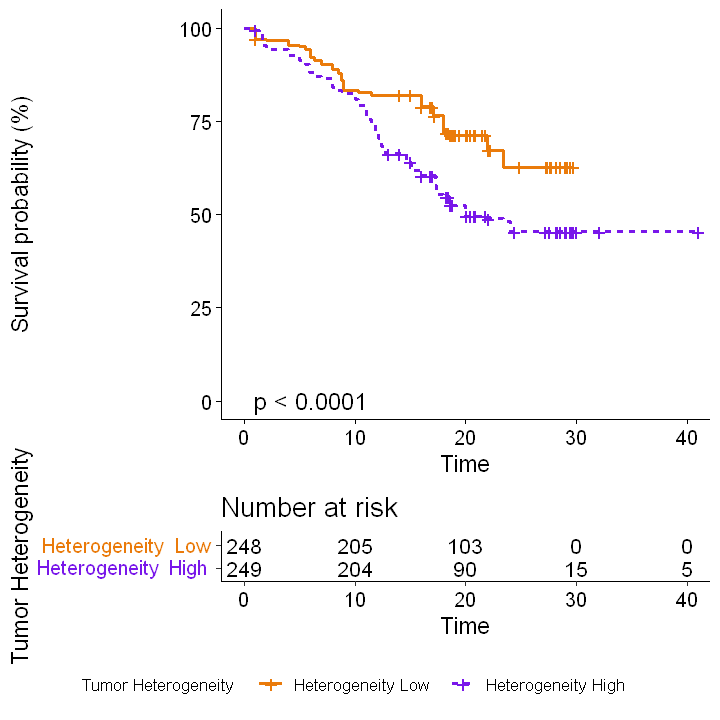

In [5]:
library(survival)
library(survminer)

MR_survival_gene_data<-fread("Fig5F.MR_survival_gene_data.test.csv") %>% as.data.frame(check.names=FALSE)
rows_selected<-!duplicated(MR_survival_gene_data$Patient_ID)
cols_selected<-colnames(MR_survival_gene_data) %in% c('Patient_ID','Gender','Age','Location','Smoking_status','Drinking_status','T','N','M','TNM','Tumor_grade','Lymphatic_metastasis','Survival_status','Survival_time')
MR_survival_data<-MR_survival_gene_data[rows_selected,cols_selected]
colnames(MR_survival_data)[1]<-"patient"

Single_T_jac_level$patient<-substr(Single_T_jac_level$sample,1,7)
MR_survival_data_jaccard<-merge(MR_survival_data,Single_T_jac_level,by="patient")
T_survival_gene<-MR_survival_data_jaccard
T_survival_gene$average_jaccard<-as.numeric(T_survival_gene$average_jaccard)

gene="average_jaccard" 
T_survival_gene$gene_flag[T_survival_gene[,gene]>median(T_survival_gene[,gene])]<-"high"# heterogeneity low
T_survival_gene$gene_flag[T_survival_gene[,gene]<=median(T_survival_gene[,gene])]<-"low"# heterogeneity high

fit<-survfit(Surv(Survival_time,Survival_status) ~gene_flag, data=T_survival_gene)

xx<-ggsurvplot(fit, data = T_survival_gene,
           conf.int = FALSE,
           pval = TRUE,
           fun = "pct",
           risk.table = TRUE,
           size = 1,
           linetype = "strata",
           palette = c(rgb(234,123,11,maxColorValue=255),rgb(121,23,234,maxColorValue=255)),
           legend = "bottom",
           legend.labs = c("Heterogeneity Low","Heterogeneity High"),
           legend.title=("Tumor Heterogeneity"),
           add.title=("Tumor Heterogeneity")
           )
print(xx)

